In [20]:
!pip install seaborn scikit-learn matplotlib pandas numpy


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score

In [22]:
# ==========================================
# 1. ПОДГОТОВКА ДАННЫХ
# ==========================================

df = pd.read_csv('famcs_students.csv')

binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
target_col = binary_cols[2 % 8] # weekend_study
print(f"Целевая переменная: {target_col}")

df[target_col] = df[target_col].map({'Да': 1, 'Нет': 0})


le = LabelEncoder()
df['weekend_study_enc'] = le.fit_transform(df['weekend_study']) # Учится ли в вых.
df['work_experience_enc'] = le.fit_transform(df['work_experience']) # Работа
df['sport_enc'] = le.fit_transform(df['sport']) # Спорт
df['sex_enc'] = le.fit_transform(df['sex']) # Пол


feature_names = ['score', 'miss', 'age', 'weekend_study_enc', 'work_experience_enc', 'sport_enc']
X = df[feature_names].values
y = df[target_col].values

X = np.nan_to_num(X)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Размеры: Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")

Целевая переменная: weekend_study
Размеры: Train (88, 6), Val (19, 6), Test (20, 6)


In [23]:
# ==========================================
# 2. РЕАЛИЗАЦИЯ МОДЕЛЕЙ
# ==========================================

# --- 0. Тривиальный классификатор ---
class TrivialClassifier:
    def fit(self, y):
        vals, counts = np.unique(y, return_counts=True)
        self.majority_class = vals[np.argmax(counts)]

    def predict(self, X):
        return np.full(X.shape[0], self.majority_class)

# --- 1. Наивный байесовский классификатор (Gaussian) ---
class NaiveBayesCustom:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.params = {}
        for c in self.classes:
            X_c = X[y == c]
            self.params[c] = {
                'mean': X_c.mean(axis=0),
                'var': X_c.var(axis=0) + 1e-9, # +epsilon чтобы не делить на 0
                'prior': X_c.shape[0] / X.shape[0]
            }

    def _pdf(self, class_idx, x):
        # Плотность вероятности Гауссова распределения
        mean = self.params[class_idx]['mean']
        var = self.params[class_idx]['var']
        numerator = np.exp(- (x - mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.params[c]['prior'])
                posterior = np.sum(np.log(self._pdf(c, x) + 1e-9))
                posteriors.append(prior + posterior)
            y_pred.append(self.classes[np.argmax(posteriors)])
        return np.array(y_pred)

    def predict_proba(self, X):
        probs = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.params[c]['prior'])
                posterior = np.sum(np.log(self._pdf(c, x) + 1e-9))
                posteriors.append(prior + posterior)
            posteriors = np.array(posteriors)
            exp_post = np.exp(posteriors - np.max(posteriors))
            probs.append(exp_post[1] / np.sum(exp_post))
        return np.array(probs)

# --- 2. Метод k-ближайших соседей (k-NN) ---
class KNNCustom:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = []
        for x in X:
            # Евклидово расстояние
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            # Голосование
            vals, counts = np.unique(k_nearest_labels, return_counts=True)
            y_pred.append(vals[np.argmax(counts)])
        return np.array(y_pred)

    def predict_proba(self, X):
        probs = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            # Доля соседей класса 1
            probs.append(np.mean(self.y_train[k_indices]))
        return np.array(probs)

# --- 3. Логистическая регрессия ---
class LogisticRegressionCustom:
    def __init__(self, lr=0.01, n_iters=2000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.threshold = 0.5 # Порог по умолчанию

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Градиентный спуск
        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(linear_model)

            # Градиенты
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)

    def predict(self, X):
        return (self.predict_proba(X) > self.threshold).astype(int)



Лучшее k для KNN: 1
Лучший порог для LogReg: 0.01 (F1=1.00)


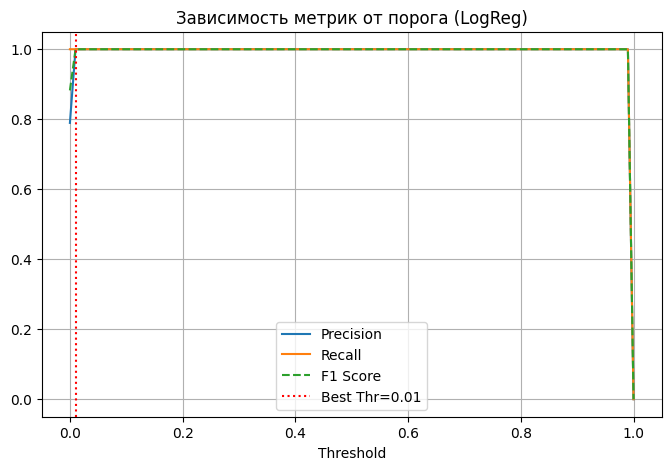

In [24]:
# ==========================================
# 3. ОБУЧЕНИЕ И ПОДБОР ГИПЕРПАРАМЕТРОВ
# ==========================================

# 1. Trivial
model_triv = TrivialClassifier()
model_triv.fit(y_train)
y_pred_triv = model_triv.predict(X_test)

# 2. Naive Bayes
model_nb = NaiveBayesCustom()
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)
y_prob_nb = model_nb.predict_proba(X_test)

# 3. k-NN (Подбор k на Val)
best_k = 1
best_acc = 0
for k in range(1, 20, 2):
    knn = KNNCustom(k=k)
    knn.fit(X_train, y_train)
    acc = np.mean(knn.predict(X_val) == y_val)
    if acc > best_acc:
        best_k = k
        best_acc = acc
print(f"Лучшее k для KNN: {best_k}")

model_knn = KNNCustom(k=best_k)
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)
y_prob_knn = model_knn.predict_proba(X_test)

# 4. LogReg (Подбор порога на Val)
model_lr = LogisticRegressionCustom(lr=0.1, n_iters=2000)
model_lr.fit(X_train, y_train)
val_probs = model_lr.predict_proba(X_val)

# Перебор порогов
thresholds = np.linspace(0, 1, 101)
f1_scores = []
precisions = []
recalls = []
best_f1 = -1
best_thresh = 0.5

for t in thresholds:
    preds = (val_probs > t).astype(int)
    # Считаем F1 вручную или через sklearn
    # F1 = 2 * (P * R) / (P + R)
    tp = np.sum((preds == 1) & (y_val == 1))
    fp = np.sum((preds == 1) & (y_val == 0))
    fn = np.sum((preds == 0) & (y_val == 1))

    p = tp / (tp + fp + 1e-9)
    r = tp / (tp + fn + 1e-9)
    f1 = 2 * p * r / (p + r + 1e-9)

    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Лучший порог для LogReg: {best_thresh:.2f} (F1={best_f1:.2f})")
model_lr.threshold = best_thresh
y_pred_lr = model_lr.predict(X_test)
y_prob_lr = model_lr.predict_proba(X_test)

# График Precision/Recall/F1
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score', linestyle='--')
plt.axvline(best_thresh, color='r', linestyle=':', label=f'Best Thr={best_thresh:.2f}')
plt.title('Зависимость метрик от порога (LogReg)')
plt.xlabel('Threshold')
plt.legend()
plt.grid(True)
plt.show()




--- Trivial ---
Accuracy:  0.7500
Precision: 0.7500
Recall:    1.0000


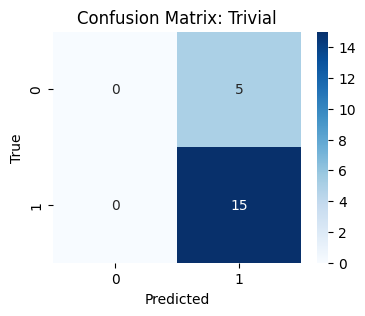


--- Naive Bayes ---
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
ROC-AUC:   1.0000


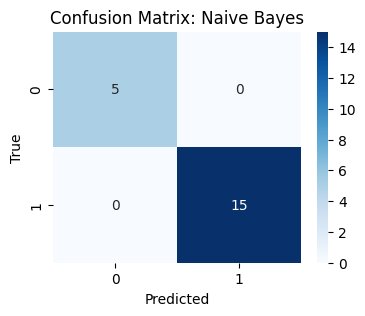


--- KNN (k=1) ---
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
ROC-AUC:   1.0000


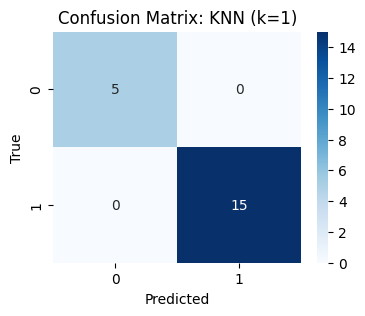


--- LogReg (T=0.01) ---
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
ROC-AUC:   1.0000


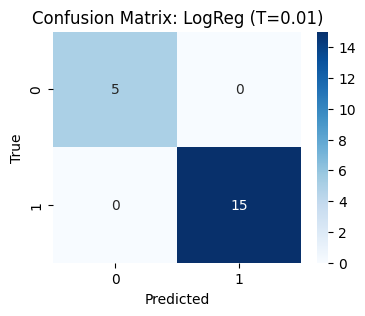

In [25]:
# ==========================================
# 4. ОЦЕНКА КАЧЕСТВА
# ==========================================

def evaluate(name, y_true, y_pred, y_prob=None):
    print(f"\n--- {name} ---")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    if y_prob is not None:
        print(f"ROC-AUC:   {roc_auc_score(y_true, y_prob):.4f}")

    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate("Trivial", y_test, y_pred_triv)
evaluate("Naive Bayes", y_test, y_pred_nb, y_prob_nb)
evaluate(f"KNN (k={best_k})", y_test, y_pred_knn, y_prob_knn)
evaluate(f"LogReg (T={best_thresh:.2f})", y_test, y_pred_lr, y_prob_lr)